In [1]:
from generate_data import *
import numpy as np
import cvxpy as cp
import warnings
warnings.filterwarnings("ignore")

global k, vk

In [2]:
Ts = 0.1

N = 10
Nu = 6
Lambda = 5e-1

# 1 - population, 2 - tracking, 3 - hiv
process = 1

In [3]:
if process == 1:
    x0 = [50, 20]
    y_zad = get_reference_population(x0)
    fun = population
    kmax, vk = len(y_zad), 0
    u = 5 * np.ones(kmax+Nu+N)
    bds = 100
    model = get_population_model(Ts, thr=1e-4, deg=2)
elif process == 2:
    x0 = [0, 0, 0]
    y_zad = get_reference_tracking(x0)
    fun = tracking
    kmax, vk = len(y_zad), 0
    u = np.zeros(kmax+Nu+N)
    bds = 0.01
    model = get_tracking_model(Ts, thr=1e-5, deg=3)
else:
    x05_stable = 0.05
    x0 = [11/20, 10/3, x05_stable, 0.0835-x05_stable, x05_stable]
    y_zad = get_reference_hiv(x0)
    fun = hiv
    kmax, vk = len(y_zad), 0
    u = 533/1078 * np.ones(kmax+Nu+N)
    bds = 1
    model = get_hiv_model(Ts, thr=1e-4, deg=3)

y_zad_N = np.vstack([y_zad, np.tile(y_zad[-1], (N, 1))])
x = np.zeros((kmax+N, len(x0)))
x[0:5, :] = x0

# 1. Stable initial condition: x1 = 5*x2-10*u, np. x, u = [(50, 20), 0]

(x1)[k+1] = 1.0500 x1[k] + -0.0025 x1[k] x2[k]
(x2)[k+1] = 0.9500 x2[k] + 0.1000 u[k] + 0.0005 x1[k] x2[k]


In [4]:
def A_sum(A, n):
    result = np.zeros(A.shape)
    for i in range(n+1):
        result += np.linalg.matrix_power(A, i)
    return result


def mpc_npl(model, state_est, u_prev, w):
    nx, nu = len(state_est), 1

    A, B = linearize(model, state_est, u_prev)

    P = np.zeros((nx*N, nu*Nu))
    xo = np.zeros((N, nx))

    for i in range(N):
        for j in range(min(i+1, Nu)):
            if i == j:
                P[nx*i:nx*(i+1), nu*j:nu*(j+1)] = B
            else:
                P[nx*i:nx*(i+1), nu*j:nu*(j+1)] = A_sum(A, i-j) @ B
        if i == 0:
            xo[i, :] = model.simulate(state_est, t=2, u=np.array([u_prev]))[-1] + vk
        else:
            xo[i, :] = model.simulate(xo[i-1, :], t=2, u=np.array([u_prev]))[-1] + vk

    C = np.eye(nx)
    C_bar = np.kron(np.eye(N), C)
    wx0 = (w * xo).reshape(-1, 1)
    y0 = C_bar @ wx0
    Yref = (w * y_zad_N[k] * np.ones((N, 1))).reshape(-1, 1)

    du = cp.Variable((nu*Nu, 1))
    cost = cp.sum_squares(Yref - C_bar @ P @ du - y0) + Lambda * cp.sum_squares(du)

    prob = cp.Problem(cp.Minimize(cost), constraints=[du >= -bds, du <= bds])
    prob.solve()

    return du.value[0, 0]

In [5]:
state = x0
w = [0, 1]

for k in range(5, kmax):
    xmod = model.simulate(state, t=2, u=np.array([u[k-1]]))[-1]
    state = fun(t=0, state=state, T=Ts, u=u[k-1])

    x[k, :] = state

    try:
        du = mpc_npl(model, state, u[k-1], w)
    except Exception as e:
        print(f"NPL failed at step {k}: {e}")
        du = 0

    u[k] = u[k-1] + du
    # u[k] = np.clip(u[k], -10, 10)
    vk = state - xmod

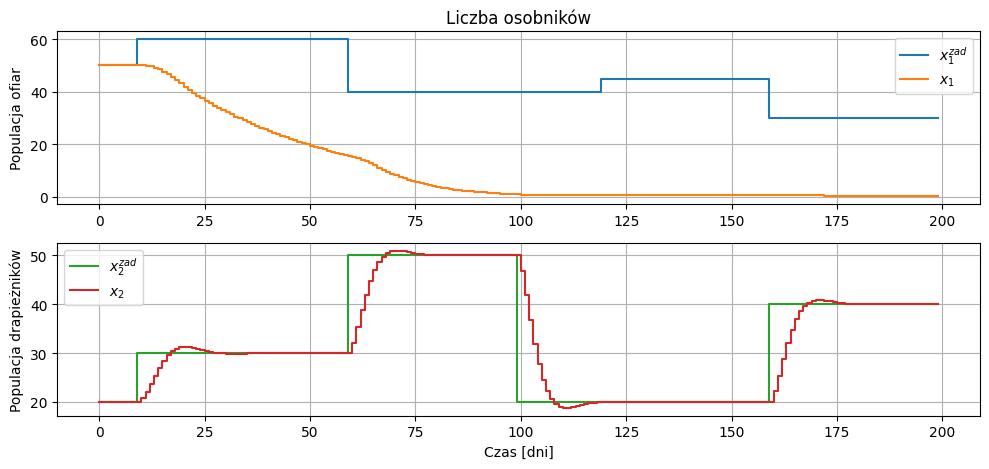

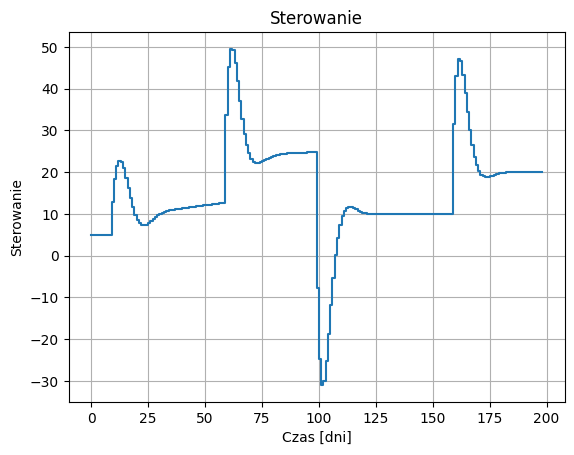

In [6]:
plot(y_zad, x, u, w, save=False)